<a href="https://colab.research.google.com/github/Sercan-dev/Bitcoin_sentiment_analysis/blob/main/bitcoin_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --depth=1 https://github.com/twintproject/twint.git
!cd /content/twint && pip3 install . -r requirements.txt 
!pip install aiohttp==3.7.0
!pip install yfinance
!pip install transformers
import twint
import nest_asyncio
nest_asyncio.apply()
import time
import pandas as pd
import numpy as np
import os
import re
import yfinance as yf

I used [twint](https://github.com/twintproject/twint) to scrape tweets from twitter to avoid the API limitation of the official Twitter api

In [ ]:
# I used twint to scrape tweets from twitter to avoid the API limitation of the official Twitter api

# Configure the twint-object
timestr = time.strftime("%Y%m%d")
c = twint.Config()
c.Limit = 30000
c.Since = "2022-07-08 00:00:00"
#config.Until = "2020–04–29"
c.Lang = "en"
c.Store_csv = True
c.Search = "bitcoin"
c.Output = timestr + "_en_bitcoin.csv"
twint.run.Search(c)


%time

In [ ]:
data = pd.read_csv('/content/20220709_en_bitcoin.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.shape

(30001, 36)

In [ ]:
# Display more columns
pd.options.display.max_columns = 100
# Display the whole tweet by maximizing columns width
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.DataFrame(data,columns=['created_at', 'tweet','language'])

In [ ]:
# Filter all tweets that are in english
df = df.loc[df['language'] == 'en']

In [ ]:
df.shape

(22217, 3)

In [ ]:
#set index to datetime format
df.set_index('created_at', inplace=True)

In [ ]:
df_clean = pd.DataFrame(df,columns=['tweet'])

In [ ]:
#Clean the Text

##Create a function to clean the tweets

def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9]+','',text) #Removing @mentions
  text = re.sub(r'#',' ',text) #Removing the '#' symbol
  text = re.sub(r'_',' ',text) #Removing the '_' symbol
  text = re.sub(r'RT[\s]+','',text) #Removing RT
  text = re.sub(r'https?:\/\/\S+','',text) #Removing RT

  return text


df_clean['tweet']= df_clean['tweet'].apply(cleanTxt)

df_clean.head()

,tweet
created_at,
2022-07-09 08:48:49 UTC,"If you’re not accumulating and investing during this dip you will not be wealthy when this thing takes off. The world’s largest non-exchange Bitcoin whale has purchased 901 $BTC ($19 million) so far in July and is now holding a total of 132,323 BTC worth $2.86 billion."
2022-07-09 08:48:45 UTC,"Long term Bull. But I think if it wicks up here, it'll be a bull trap before the eventual leg down to 10-12k. Which will be a generational buy signal. Bitcoin"
2022-07-09 08:48:42 UTC,Eid Mubarak to everyone who is celebrating! 🥳 🌙 I hope the Saudis buy and pump bitcoin to celebrate! 🚀🔥
2022-07-09 08:48:37 UTC,"Bitcoin Might Spike by 10% as Ethereum Already Flirting with $1,200, Here's Why . Cryptocurrency market might feel short-term relief if U.S. Dollar's party is finally over."
2022-07-09 08:48:35 UTC,"Bitcoin, Etherum &amp; Litecoin now accepted in Osteria Romana -"


# Pretrained transformer model

For the sentiment analysis I used a pretrained transformers model from the [Hugging Face](https://huggingface.co/siebert/sentiment-roberta-large-english) library. 

In [ ]:
# Import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
# Load tokenizer and model, create trainer
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [ ]:
# Example: Import data from csv-file stored on Google Drive
text_column = "tweet"

df_pred = df_clean
pred_texts = df_pred[text_column].dropna().astype('str').tolist()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# Run predictions
predictions = trainer.predict(pred_dataset)

***** Running Prediction *****
  Num examples = 22217
  Batch size = 8


In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip( pred_texts,preds,labels,scores)), columns=['tweet','pred','label','score'])
df

,tweet,pred,label,score
0,"If you’re not accumulating and investing during this dip you will not be wealthy when this thing takes off. The world’s largest non-exchange Bitcoin whale has purchased 901 $BTC ($19 million) so far in July and is now holding a total of 132,323 BTC worth $2.86 billion.",1,POSITIVE,0.995291
1,"Long term Bull. But I think if it wicks up here, it'll be a bull trap before the eventual leg down to 10-12k. Which will be a generational buy signal. Bitcoin",1,POSITIVE,0.992615
2,Eid Mubarak to everyone who is celebrating! 🥳 🌙 I hope the Saudis buy and pump bitcoin to celebrate! 🚀🔥,1,POSITIVE,0.998801
3,"Bitcoin Might Spike by 10% as Ethereum Already Flirting with $1,200, Here's Why . Cryptocurrency market might feel short-term relief if U.S. Dollar's party is finally over.",1,POSITIVE,0.997177
4,"Bitcoin, Etherum &amp; Litecoin now accepted in Osteria Romana -",1,POSITIVE,0.995366
...,...,...,...,...
22212,Why the Voyager Bankruptcy is the last straw for some crypto HODLers. cryptocurrency is for GAMBLERS. Another blunder of a pinoy Investing influencer recommending Bitcoin before it was all JFC jollibee then Millions worth of investment lost 🤣,0,NEGATIVE,0.999074
22213,"$GXS / USDT Volume increase detected! Spike: 171,903.92 USDT 24h Vol: 0.00 USDT Get ALL the alerts here: crypto bitcoin binance altcoins hodl defi trading freedom blockchain $btc $st $stbusd $yfii $ldo $trb $mbl $elf $vidt",1,POSITIVE,0.996533
22214,"Crypto Traders Lose $280 Million Following Bitcoin’s Break Above $22,000",0,NEGATIVE,0.998535
22215,"computerart creativecoding generativeart : bitcoin blockchain 's LAST Block, Height : 744175 [ See more on ]",1,POSITIVE,0.996755


In [ ]:
#set index to datetime format again

df.index = pd.to_datetime(df_pred.index)

In [ ]:
df

,tweet,pred,label,score
created_at,,,,
2022-07-09 08:48:49+00:00,"If you’re not accumulating and investing during this dip you will not be wealthy when this thing takes off. The world’s largest non-exchange Bitcoin whale has purchased 901 $BTC ($19 million) so far in July and is now holding a total of 132,323 BTC worth $2.86 billion.",1,POSITIVE,0.995291
2022-07-09 08:48:45+00:00,"Long term Bull. But I think if it wicks up here, it'll be a bull trap before the eventual leg down to 10-12k. Which will be a generational buy signal. Bitcoin",1,POSITIVE,0.992615
2022-07-09 08:48:42+00:00,Eid Mubarak to everyone who is celebrating! 🥳 🌙 I hope the Saudis buy and pump bitcoin to celebrate! 🚀🔥,1,POSITIVE,0.998801
2022-07-09 08:48:37+00:00,"Bitcoin Might Spike by 10% as Ethereum Already Flirting with $1,200, Here's Why . Cryptocurrency market might feel short-term relief if U.S. Dollar's party is finally over.",1,POSITIVE,0.997177
2022-07-09 08:48:35+00:00,"Bitcoin, Etherum &amp; Litecoin now accepted in Osteria Romana -",1,POSITIVE,0.995366
...,...,...,...,...
2022-07-08 18:00:13+00:00,Why the Voyager Bankruptcy is the last straw for some crypto HODLers. cryptocurrency is for GAMBLERS. Another blunder of a pinoy Investing influencer recommending Bitcoin before it was all JFC jollibee then Millions worth of investment lost 🤣,0,NEGATIVE,0.999074
2022-07-08 18:00:12+00:00,"$GXS / USDT Volume increase detected! Spike: 171,903.92 USDT 24h Vol: 0.00 USDT Get ALL the alerts here: crypto bitcoin binance altcoins hodl defi trading freedom blockchain $btc $st $stbusd $yfii $ldo $trb $mbl $elf $vidt",1,POSITIVE,0.996533
2022-07-08 18:00:11+00:00,"Crypto Traders Lose $280 Million Following Bitcoin’s Break Above $22,000",0,NEGATIVE,0.998535


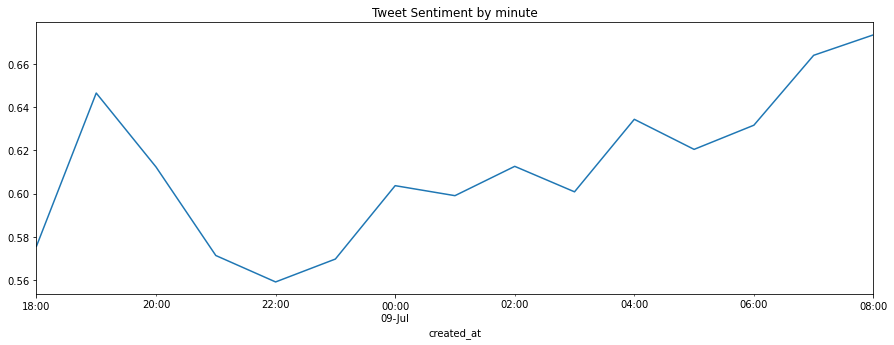

In [ ]:
#resample timeframe to hourly and get the mean value

df.resample('H')['pred'].mean().plot(figsize=(15,5),
    title="Tweet Sentiment by minute");

# Get the price quote

Now I get the Bitcoin price quote to see if there is a correlation in the hourly closing price of Bitcoin and the hourly twitter sentiment

In [ ]:
#Get the price quote of bitcoin

import yfinance as yf
Price = yf.download('BTC-USD', period="2d", interval = "1h")


[*********************100%***********************]  1 of 1 completed


In [ ]:
Price

,Open,High,Low,Close,Adj Close,Volume
2022-07-08 00:00:00+00:00,21628.207031,21684.642578,21591.224609,21682.662109,21682.662109,0
2022-07-08 01:00:00+00:00,21691.935547,22314.941406,21660.421875,22093.298828,22093.298828,1998039040
2022-07-08 02:00:00+00:00,22099.253906,22113.138672,21939.572266,21961.554688,21961.554688,291041280
2022-07-08 03:00:00+00:00,21975.769531,22096.951172,21951.935547,22096.951172,22096.951172,385069056
2022-07-08 04:00:00+00:00,22098.310547,22164.042969,22000.345703,22000.345703,22000.345703,266049536
2022-07-08 05:00:00+00:00,21984.708984,22037.244141,21818.457031,21852.273438,21852.273438,307120128
2022-07-08 06:00:00+00:00,21854.007812,21854.873047,21780.455078,21823.867188,21823.867188,268306432
2022-07-08 07:00:00+00:00,21822.609375,21832.119141,21759.175781,21808.798828,21808.798828,158042112
2022-07-08 08:00:00+00:00,21798.777344,21809.375000,21588.974609,21588.974609,21588.974609,173469696
2022-07-08 09:00:00+00:00,21547.982422,21547.982422,21348.123047,21511.693359,21511.693359,650344448


In [ ]:
Price = pd.DataFrame(Price,columns=['Close'])
Price

,Close
2022-07-08 00:00:00+00:00,21682.662109
2022-07-08 01:00:00+00:00,22093.298828
2022-07-08 02:00:00+00:00,21961.554688
2022-07-08 03:00:00+00:00,22096.951172
2022-07-08 04:00:00+00:00,22000.345703
2022-07-08 05:00:00+00:00,21852.273438
2022-07-08 06:00:00+00:00,21823.867188
2022-07-08 07:00:00+00:00,21808.798828
2022-07-08 08:00:00+00:00,21588.974609
2022-07-08 09:00:00+00:00,21511.693359


In [ ]:
#resample timeframe to hourly and get the mean value

sentiment = pd.DataFrame(df.resample('H')['pred'].mean())
sentiment

,pred
created_at,
2022-07-08 18:00:00+00:00,0.575701
2022-07-08 19:00:00+00:00,0.646543
2022-07-08 20:00:00+00:00,0.612362
2022-07-08 21:00:00+00:00,0.571429
2022-07-08 22:00:00+00:00,0.559206
2022-07-08 23:00:00+00:00,0.569791
2022-07-09 00:00:00+00:00,0.603722
2022-07-09 01:00:00+00:00,0.599096
2022-07-09 02:00:00+00:00,0.612654


In [ ]:
Price = Price.truncate(before='2022-07-08 18:00:10 UTC')

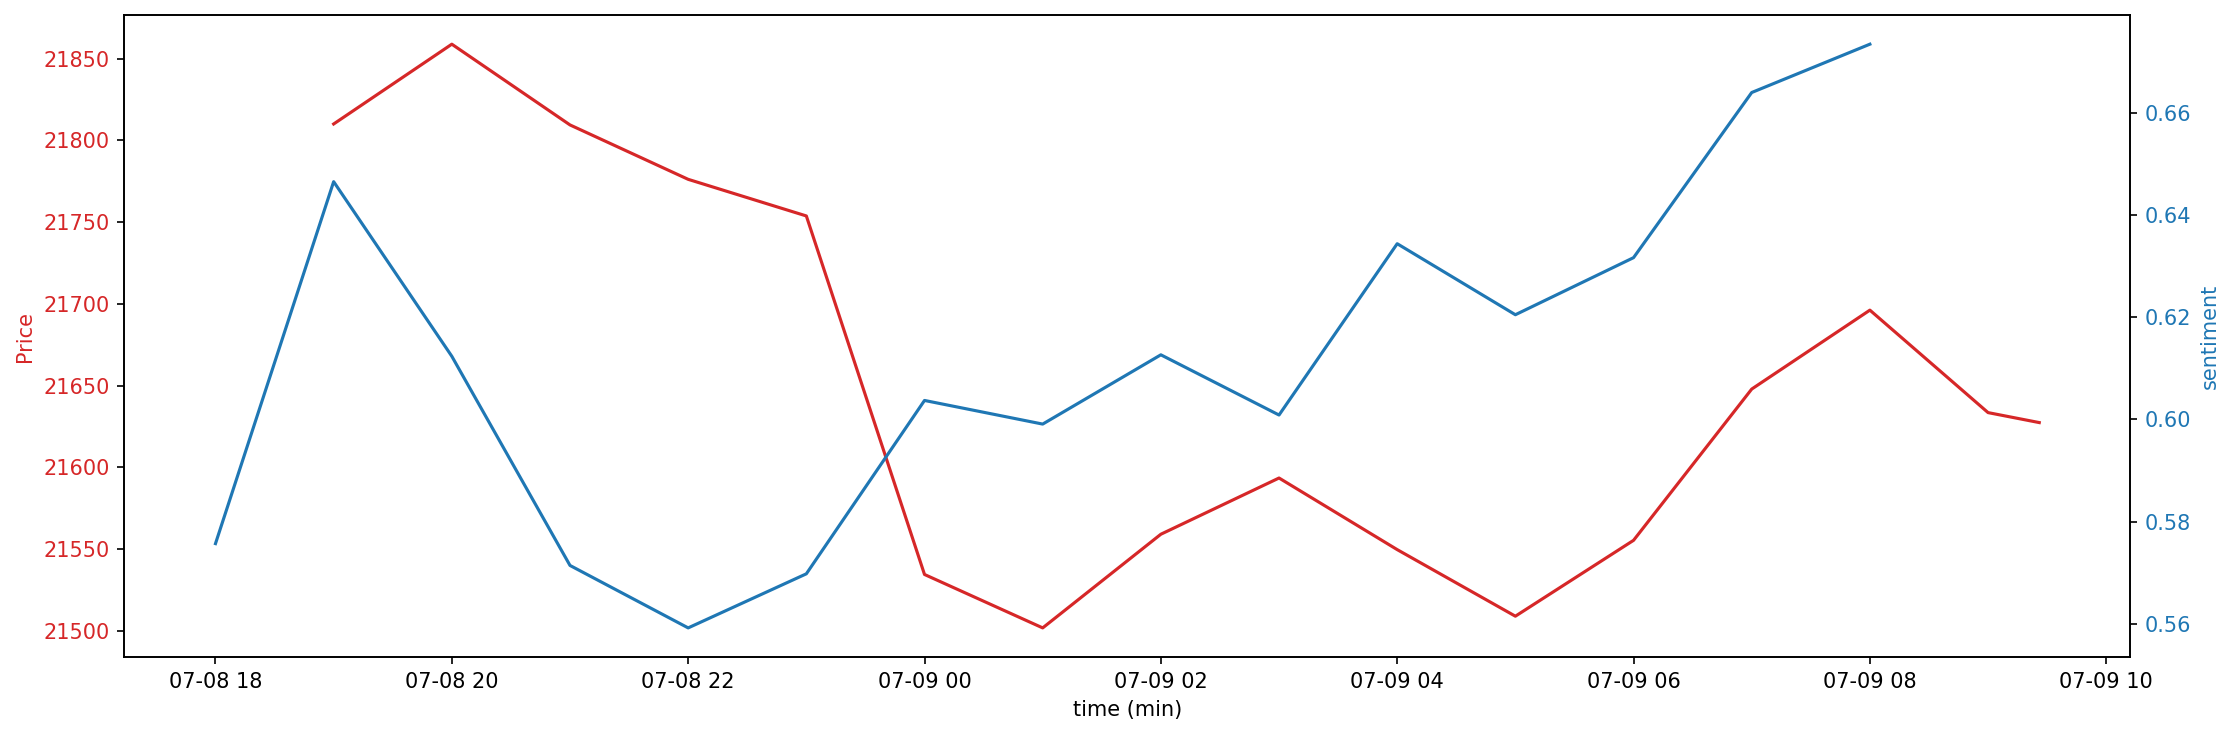

In [ ]:
# Create a twin Axes sharing the xaxis with .twinx()

from matplotlib import pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 5), dpi=150)



color = 'tab:red'
ax1.set_xlabel('time (min)')
ax1.set_ylabel('Price', color=color)
ax1.plot( Price, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sentiment', color=color)  # we already handled the x-label with ax1
ax2.plot( sentiment , color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Observation

It seems that the Twitter sentiment and the close price of bitcoin are correlated during this past hours. Of course, a larger timespan would provide greater confidence — but this provides us with an initial positive outcome to investigate further.

